In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import torch
plt.rcParams['figure.figsize'] = [18, 12]

In [2]:
img_path="000000001580.jpg"

In [3]:
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Image Not Found {img_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
original_image=img

In [5]:
img.dtype

dtype('uint8')

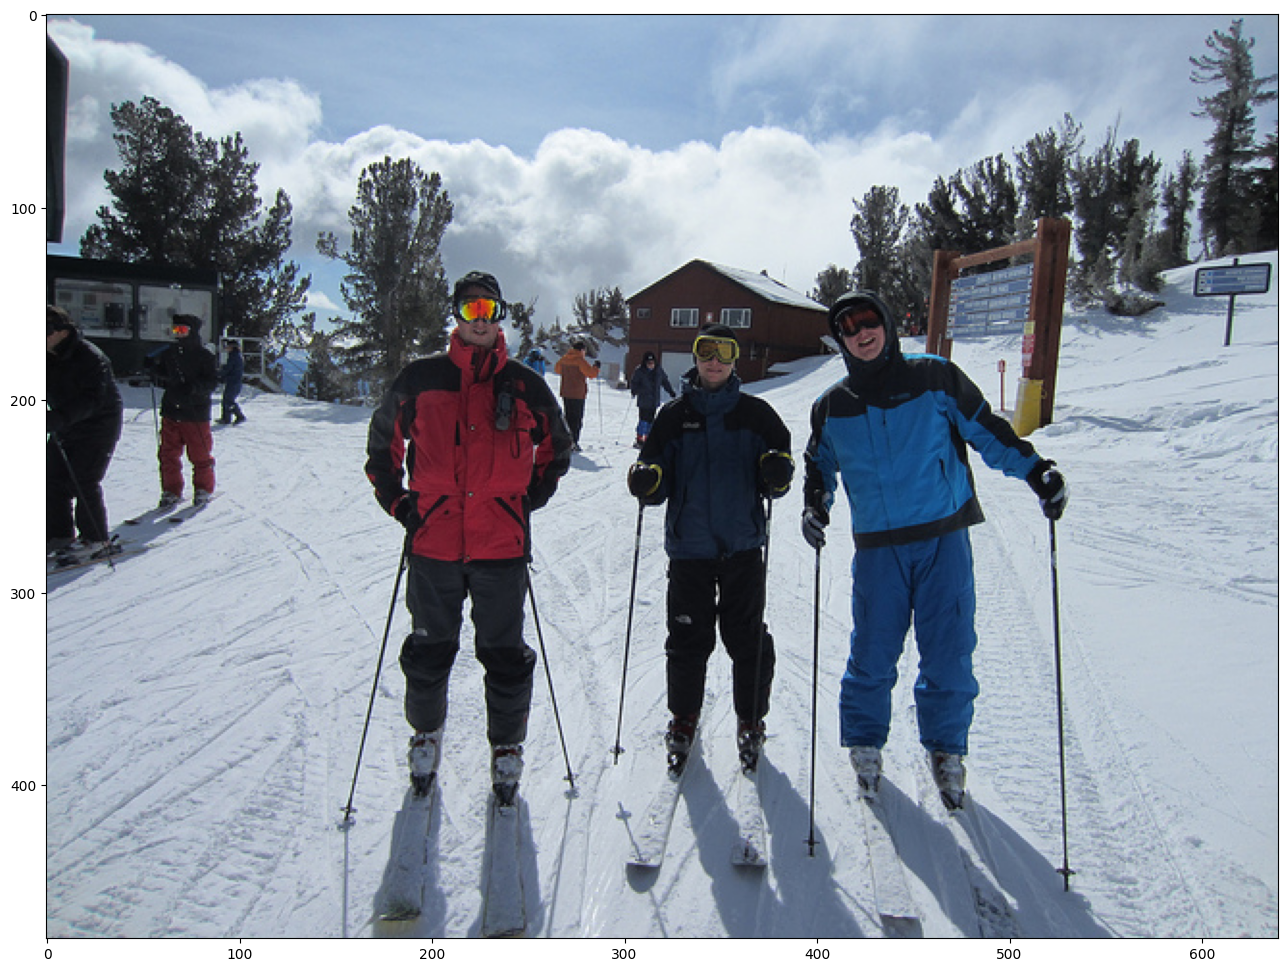

In [4]:
plt.imshow(img)
plt.show()

current shape (height, width)

In [5]:
img.shape

(480, 640, 3)

In [6]:
shape=img.shape[:2]

In [7]:
shape

(480, 640)

In [8]:
new_shape = (640, 640)

In [9]:
scale_ratio = min(new_shape[0] / shape[0], new_shape[1] / shape[1])

In [10]:
scale_ratio

1.0

only scale down, do not scale up (for better val mAP)

In [11]:
scale_ratio = min(scale_ratio, 1.0)

In [12]:
scale_ratio

1.0

In [13]:
new_unpad = int(round(shape[1] * scale_ratio)), int(round(shape[0] * scale_ratio))

In [14]:
new_unpad

(640, 480)

In [15]:
dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

In [16]:
print(f"dw={dw}, dh={dh}")

dw=0, dh=160


divide padding into 2 sides

In [17]:
dw /= 2

In [18]:
dh /= 2

In [19]:
print(f"dw={dw}, dh={dh}")

dw=0.0, dh=80.0


In [20]:
shape[::-1]

(640, 480)

In [21]:
if shape[::-1] != new_unpad:  # resize
    img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)

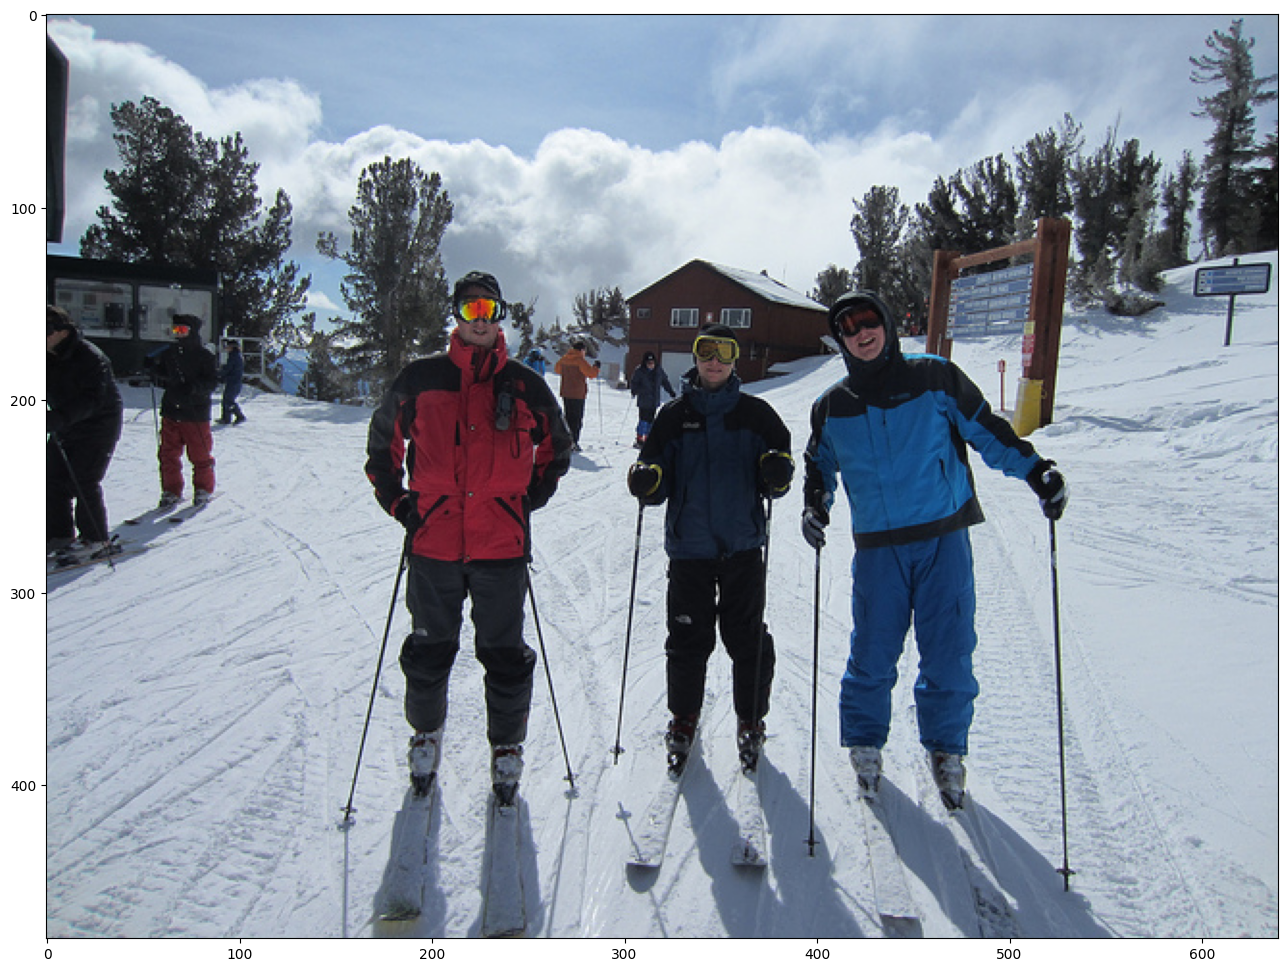

In [22]:
plt.imshow(img)
plt.show()

In [23]:
top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
left, right = int(round(dw - 0.1)), int(round(dw + 0.1))

In [24]:
print(f"top={top}, bottom={bottom}, left={left}, right={right}")

top=80, bottom=80, left=0, right=0


In [25]:
img = cv2.copyMakeBorder(
    img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(114, 114, 114)
)  # add border

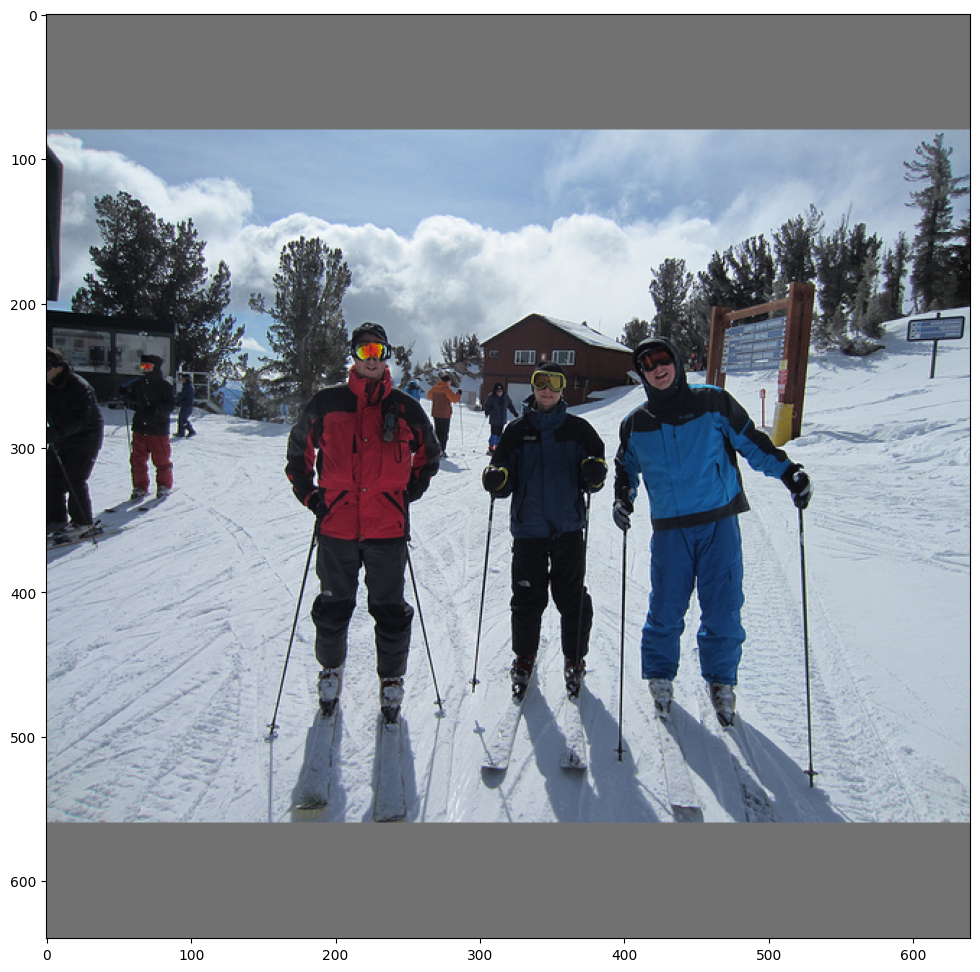

In [26]:
plt.imshow(img)
plt.show()

In [27]:
img.shape

(640, 640, 3)

In [28]:
img=np.stack([img])

In [29]:
img.shape

(1, 640, 640, 3)

BHWC to BCHW, (n, 3, h, w)

In [30]:
img = img[..., ::-1]

In [31]:
img.shape

(1, 640, 640, 3)

In [32]:
img=img.transpose((0, 3, 1, 2))

In [33]:
img.shape

(1, 3, 640, 640)

In [34]:
img=np.ascontiguousarray(img)

In [35]:
img = torch.from_numpy(img)

In [36]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [37]:
device

'cuda'

In [38]:
img=img.to(device)

0 - 255 to 0.0 - 1.0

In [39]:
img=img.float()

In [40]:
img /= 255

In [41]:
ckpt = torch.load('yolov8s.pt', map_location="cpu")

In [42]:
ckpt?

Type:        dict
String form:
{'epoch': -1, 'best_fitness': None, 'model': DetectionModel(
           (model): Sequential(
           (0): Conv <...> 0, 'cfg': None, 'v5loader': True}, 'date': '2022-12-30T08:15:10.989874', 'version': '8.0.0.dev0'}
Length:      9
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)

In [43]:
model = ckpt["model"]

In [44]:
model?

Signature:      model(*args, **kwargs)
Type:           DetectionModel
String form:   
DetectionModel(
           (model): Sequential(
           (0): Conv(
           (conv): Conv2d(3, 32, kernel_size=(3, <...>
           (conv): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
           )
           )
           )
           )
File:           /opt/conda/lib/python3.10/site-packages/ultralytics/nn/tasks.py
Docstring:      YOLOv8 detection model.
Init docstring: Initialize the YOLOv8 detection model with the given config and parameters.

In [45]:
model= model.to(device).float().fuse().eval()

YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs


In [46]:
result = model(img)

In [47]:
result?

Type:        tuple
String form:
(tensor([[[1.0299e+01, 1.3502e+01, 1.8655e+01,  ..., 5.5911e+02, 5.9596e+02, 6.0850e+02],
           <...>         [-13.5012, -13.5966, -13.8781,  ..., -13.6725, -13.6660, -13.4761]]]], device='cuda:0')])
Length:      2
Docstring:  
Built-in immutable sequence.

If no argument is given, the constructor returns an empty tuple.
If iterable is specified the tuple is initialized from iterable's items.

If the argument is a tuple, the return value is the same object.

In [48]:
result[0].shape

torch.Size([1, 84, 8400])

In [49]:
result[1]?

Type:        list
String form:
[tensor([[[[  7.2942,   3.8939,   2.9731,  ...,   4.0055,   3.4143,   1.4551],
           [  7.229 <...>          [-13.5012, -13.5966, -13.8781,  ..., -13.6725, -13.6660, -13.4761]]]], device='cuda:0')]
Length:      3
Docstring:  
Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified.

In [50]:
for x in result[1]:
    print(x.shape)

torch.Size([1, 144, 80, 80])
torch.Size([1, 144, 40, 40])
torch.Size([1, 144, 20, 20])


In [51]:
outputs=result[0].to('cpu').numpy()

In [52]:
outputs=np.array([cv2.transpose(outputs[0])])

In [53]:
rows=outputs.shape[1]

In [54]:
rows

8400

In [55]:
boxes = []
scores = []
class_ids = []

# Iterate through output to collect bounding boxes, confidence scores, and class IDs
for i in range(rows):
    classes_scores = outputs[0][i][4:]
    (minScore, maxScore, minClassLoc, (x, maxClassIndex)) = cv2.minMaxLoc(classes_scores)
    if maxScore >= 0.25:
        box = [
            outputs[0][i][0] - (0.5 * outputs[0][i][2]),
            outputs[0][i][1] - (0.5 * outputs[0][i][3]),
            outputs[0][i][2],
            outputs[0][i][3],
        ]
        boxes.append(box)
        scores.append(maxScore)
        class_ids.append(maxClassIndex)

In [56]:
result_boxes = cv2.dnn.NMSBoxes(boxes, scores, 0.25, 0.45, 0.5)

In [57]:
result_boxes

array([74, 69, 78, 36, 37, 10, 53, 27,  2, 59, 47], dtype=int32)

In [58]:
from ultralytics.utils import ASSETS, yaml_load
from ultralytics.utils.checks import check_yaml
CLASSES = yaml_load(check_yaml("coco.yaml"))["names"]
colors = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [59]:
def draw_bounding_box(image, class_id, confidence, x, y, x_plus_w, y_plus_h):
    """
    Draws bounding boxes on the input image based on the provided arguments.

    Args:
        img (numpy.ndarray): The input image to draw the bounding box on.
        class_id (int): Class ID of the detected object.
        confidence (float): Confidence score of the detected object.
        x (int): X-coordinate of the top-left corner of the bounding box.
        y (int): Y-coordinate of the top-left corner of the bounding box.
        x_plus_w (int): X-coordinate of the bottom-right corner of the bounding box.
        y_plus_h (int): Y-coordinate of the bottom-right corner of the bounding box.
    """
    label = f"{CLASSES[class_id]} ({confidence:.2f})"
    color = colors[class_id]
    cv2.rectangle(image, (x, y), (x_plus_w, y_plus_h), color, 2)
    cv2.putText(image, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

In [60]:
detections = []

# Iterate through NMS results to draw bounding boxes and labels
for i in range(len(result_boxes)):
    index = result_boxes[i]
    box = boxes[index]
    detection = {
        "class_id": class_ids[index],
        "class_name": CLASSES[class_ids[index]],
        "confidence": scores[index],
        "box": box,
        "scale": scale_ratio,
    }
    detections.append(detection)

In [61]:
detections

[{'class_id': 0,
  'class_name': 'person',
  'confidence': 0.9304981231689453,
  'box': [392.1829071044922, 223.18978881835938, 140.25931, 271.55127],
  'scale': 1.0},
 {'class_id': 0,
  'class_name': 'person',
  'confidence': 0.9089567065238953,
  'box': [164.57168579101562, 212.60617065429688, 109.78241, 278.33887],
  'scale': 1.0},
 {'class_id': 0,
  'class_name': 'person',
  'confidence': 0.9027999043464661,
  'box': [302.1106719970703, 243.25884246826172, 87.41037, 232.41713],
  'scale': 1.0},
 {'class_id': 0,
  'class_name': 'person',
  'confidence': 0.8644822239875793,
  'box': [0.0523223876953125, 230.63009643554688, 40.695026, 133.60248],
  'scale': 1.0},
 {'class_id': 0,
  'class_name': 'person',
  'confidence': 0.7846037149429321,
  'box': [39.24203109741211, 235.02427673339844, 51.483345, 104.05716],
  'scale': 1.0},
 {'class_id': 0,
  'class_name': 'person',
  'confidence': 0.757340669631958,
  'box': [263.8134765625, 247.42361450195312, 24.218445, 59.406128],
  'scale': 1

In [62]:
for detection in detections:
    box = detection['box']
    scale = detection['scale']
    draw_bounding_box(
        original_image,
        detection['class_id'],
        detection['confidence'],
        round((box[0] - (dw)) / scale),
        round((box[1] - (dh)) / scale),
        round((box[0] + box[2] - (dw)) / scale),
        round((box[1] + box[3] - (dh)) / scale),
    )

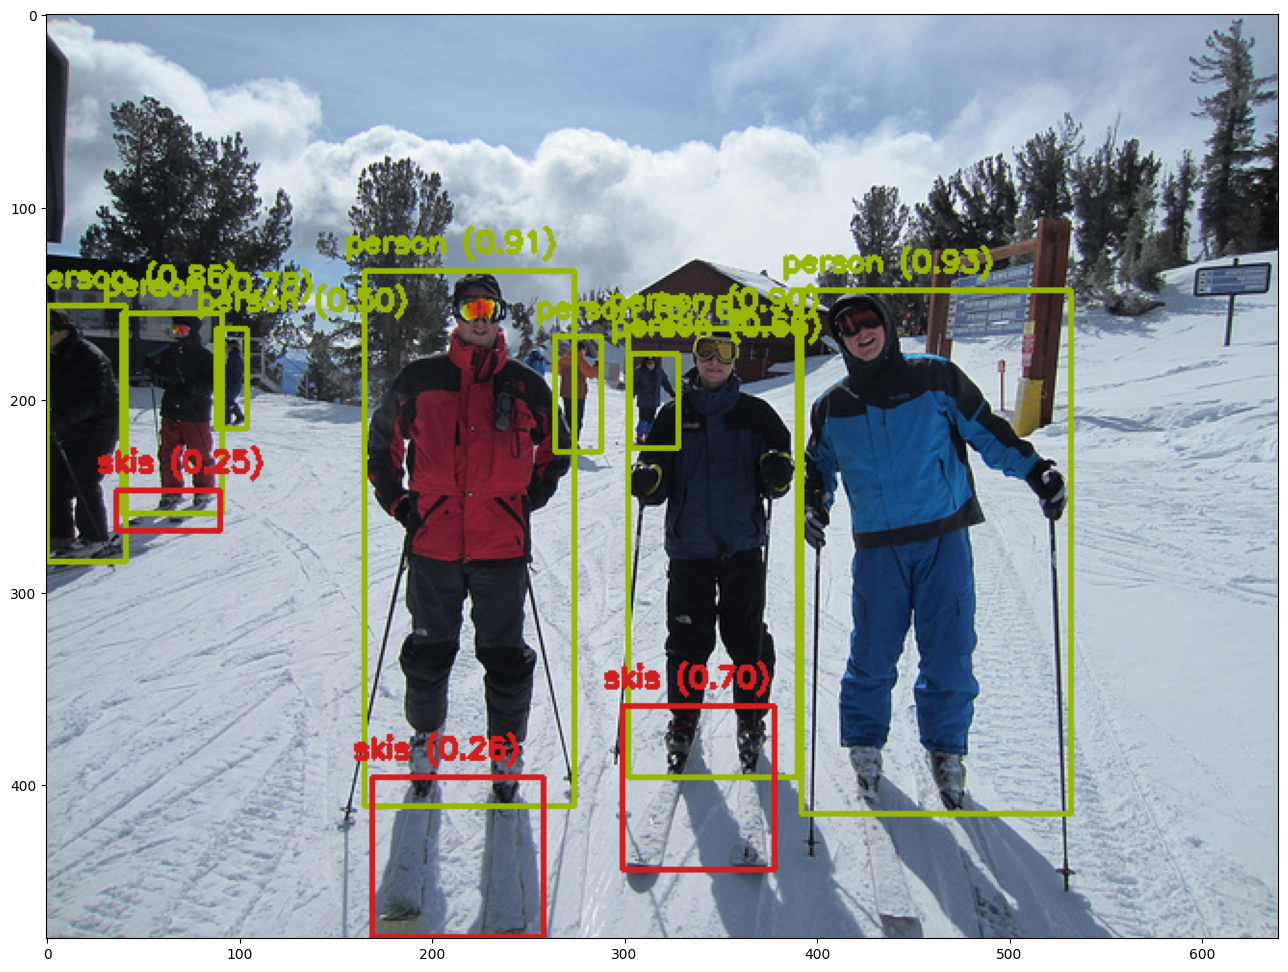

In [63]:
plt.imshow(original_image)
plt.show()

In [64]:
cv2.imwrite("result.jpg", cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR))

True